# Modeling Plan.

by Semin Kim. Last Update: 2017/01/07.

1. Compute base accuracy. 
1. Prepare a clean dataset (X,y) by applying the feature engineering from the exploratory analysis.
1. Apply a decision tree model. 
    - A decision tree is a natural first choice in this problem because features like 
     'female vs male', 'high class vs low class', 'high fare vs low fare', 'child vs old' affect survival rates. 
    - We have mostly categorical features (all except Fare). We don't need OneHotEncoding for a decision tree. 
    - Use a simple decision tree model to get a base accuracy. 
    - Draw a learning curve to see 'overfitting vs underfitting'. 
1. Tune the decision tree model. 
1. Apply a random forest model.
1. Apply a boosting tree model.
1. Apply a neural network using keras and tensorflow. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

In [3]:
df = pd.read_csv('train.csv')

# 1. Base Accuracy

- A base model is just always predicting 'Survivied=0'. 

In [4]:
survived_cnt = df.Survived.value_counts()
print('Accuracy of a Simple Guess Classifier = %.1f%%' %(survived_cnt[0]/(survived_cnt[0]+survived_cnt[1])*100))

Accuracy of a Simple Guess Classifier = 61.6%


# 2. Preprocess: feature engineering

In [5]:
from sklearn.preprocessing import LabelEncoder

def getTitle(s):
    first,last = s.split(',')
    
    last = last.strip()
    title = ''
    if last.find('.') != -1:
        title = last.split('.')[0]
        
    if title not in ['Mr', 'Mrs', 'Miss', 'Master']:
        return 'Else'
    return title

def preprocess(df):
    X = df.copy()
    
    X['title'] = X.Name.map(getTitle);

    X['familySize'] = X.SibSp + X.Parch
    X['familySize'] = X['familySize'].map(lambda x: x+1)
    
    X.Age.fillna(1000, inplace=True)
    X['ageCat'] = pd.cut(X['Age'], bins=[0,18,30,60, 100, 2000])
    
    X['cabin'] = 0
    X.loc[X.Cabin.notnull(), 'cabin'] = 1
    
    X.Fare.fillna(X.Fare.median(), inplace=True)
    
    X['Sex'] = LabelEncoder().fit_transform(X['Sex'].values)
    X['title'] = LabelEncoder().fit_transform(X['title'].values)
    X['ageCat'] = LabelEncoder().fit_transform(X['ageCat'].values)
    
    X = X[['Pclass','Sex', 'title', 'SibSp', 'Parch', 'familySize', 'Fare', 'ageCat','cabin']]
    
    return X

In [6]:
X = preprocess(df)
y = df['Survived']

In [7]:
X.head()

,Pclass,Sex,title,SibSp,Parch,familySize,Fare,ageCat,cabin
0,3,1,3,1,0,2,7.2500,2,0
1,1,0,4,1,0,2,71.2833,3,1
2,3,0,2,0,0,1,7.9250,2,0
3,1,0,4,1,0,2,53.1000,3,1
4,3,1,3,0,0,1,8.0500,3,0


# 3. Modeling with a decision tree 

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import time


def printFeatureImportance(clf, X,y):
    print('\n feature importance:')
    clf.fit(X, y)
    features = X.columns
    importances = clf.feature_importances_
    arg_sort = np.argsort(importances)[::-1]
    n = min(len(features), 10)
    for i in range(n):
        idx = arg_sort[i]
        print('%2d. %-*s %.2f %%' %(i+1,15, features[idx],importances[idx]*100))

def fitTree(X,y, estimator=DecisionTreeClassifier, param_grid=None):
    t1 = time.time()
    
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)
    
    clf = estimator()
     
    if param_grid:
        gs = GridSearchCV(estimator=clf,
                    param_grid=param_grid,
                    scoring='accuracy',
                    cv=5)
        gs = gs.fit(X_train, y_train)
        clf = gs.best_estimator_
        print('best param: ' + str(gs.best_params_))
        print('grid search time: %.2f sec.' %(time.time()-t1))
    
    train_scores = cross_val_score(estimator = clf, X=X_train, y=y_train, cv=5)
    test_scores = cross_val_score(estimator = clf, X=X_test, y=y_test, cv=5)
    
    print('train mean accuracy: %.2f %% (std=%.2f %%)' %(np.mean(train_scores)*100, np.std(train_scores)*100))
    print('test mean accuracy: %.2f %% (std=%.2f %%)' %(np.mean(test_scores)*100, np.std(test_scores)*100))
    
    printFeatureImportance(clf,X,y)
    print('\n total time: %.2f sec.' %(time.time()-t1))
    return clf

In [9]:
from sklearn.model_selection import learning_curve
def drawLearningCurve(clf, X, y):
    train_sizes, train_scores, test_scores = learning_curve(estimator=clf, X=X, y=y, cv=5, train_sizes=np.linspace(0.1,1,10))
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    plt.plot(train_sizes, train_mean, 'b-')

    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    plt.plot(train_sizes, test_mean, 'r-')

    plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.1, color='blue')
    plt.fill_between(train_sizes, test_mean-test_std, test_mean+test_std, alpha=0.1, color='red')

In [10]:
clf_dt = fitTree(X,y)
clf_dt

train mean accuracy: 76.88 % (std=2.31 %)
test mean accuracy: 74.60 % (std=4.19 %)

 feature importance:
 1. Sex             33.79 %
 2. Fare            29.87 %
 3. Pclass          9.08 %
 4. ageCat          8.64 %
 5. title           5.56 %
 6. cabin           4.35 %
 7. familySize      4.27 %
 8. SibSp           2.78 %
 9. Parch           1.65 %

 total time: 0.06 sec.


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

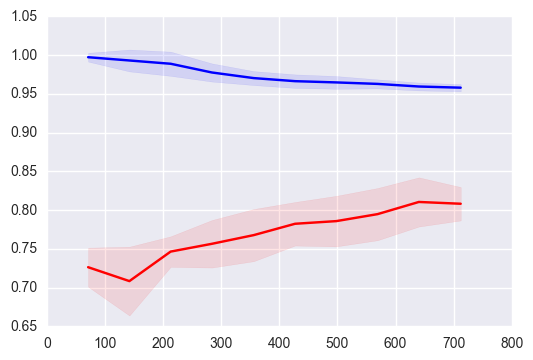

In [11]:
drawLearningCurve(clf_dt, X, y)

# 4. Modeling with a decision tree: parameter tuning 

- We implemented a simple decision tree model for sussessful prediction, with almost 20% increase in accuracy compared to simple guess. 
- However, we also see that the current model is suffering from overfitting. We use GridSearchCV for parameter tuning. 
- For a decision tree, we control 'max_depth' parameter (lower 'the depth of tree' to avoid high variance). 

In [12]:
param_grid = [ {'max_depth':[3,4,5,6,7,8]} ]

clf_dt_gs = fitTree(X,y,param_grid=param_grid)
clf_dt_gs

best param: {'max_depth': 6}
grid search time: 0.15 sec.
train mean accuracy: 80.41 % (std=3.28 %)
test mean accuracy: 77.61 % (std=4.56 %)

 feature importance:
 1. Sex             50.70 %
 2. Pclass          13.48 %
 3. familySize      9.57 %
 4. Fare            7.30 %
 5. title           7.10 %
 6. cabin           5.75 %
 7. ageCat          3.52 %
 8. Parch           1.67 %
 9. SibSp           0.92 %

 total time: 0.18 sec.


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

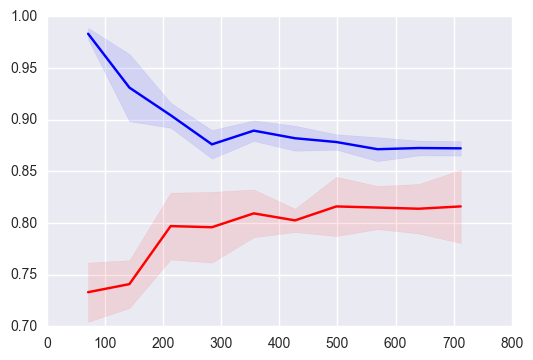

In [13]:
drawLearningCurve(clf_dt_gs, X, y)

# 5. Modeling with a random forest.

- We successfuly improved the model with an increase of 3% in accuracy. 

- On the other hand, we see that 'Sex' feature always has greatest impact, having 30-50% of explained variance. A decision tree might suffer from local minimum in optimization by always dividing 1st node by Sex (failure of Greedy algorithm). 

- To avoid this issue, we try a random forest classifier which resolve this issue by 'random feature selection at each step' and 'bootstrapping and voting classification'.  

In [14]:
clf_rf = fitTree(X,y, estimator=RandomForestClassifier)
clf_rf

train mean accuracy: 80.75 % (std=3.42 %)
test mean accuracy: 78.36 % (std=3.59 %)

 feature importance:
 1. Fare            31.07 %
 2. Sex             26.62 %
 3. title           10.22 %
 4. ageCat          9.61 %
 5. Pclass          7.37 %
 6. familySize      5.64 %
 7. cabin           4.25 %
 8. SibSp           3.03 %
 9. Parch           2.19 %

 total time: 0.22 sec.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [15]:
param_grid = [ {'n_estimators':[10, 20], 
                'max_depth':[3,5,7], 
                'max_features':[3,5,None]} ]

clf_rf_gs = fitTree(X,y, estimator=RandomForestClassifier, param_grid=param_grid)
clf_rf_gs

best param: {'n_estimators': 20, 'max_depth': 5, 'max_features': None}
grid search time: 2.55 sec.
train mean accuracy: 82.34 % (std=2.23 %)
test mean accuracy: 79.47 % (std=4.55 %)

 feature importance:
 1. Sex             50.60 %
 2. Fare            15.27 %
 3. Pclass          13.08 %
 4. title           5.89 %
 5. familySize      5.13 %
 6. cabin           4.04 %
 7. ageCat          3.09 %
 8. SibSp           2.11 %
 9. Parch           0.80 %

 total time: 2.91 sec.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

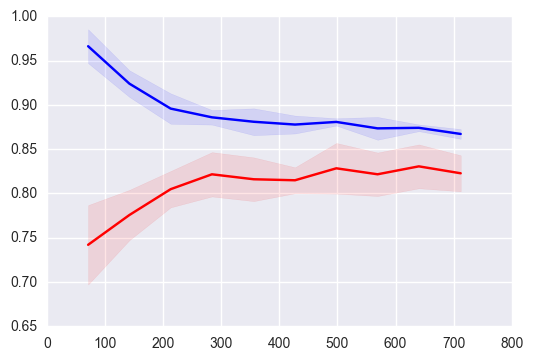

In [16]:
drawLearningCurve(clf_rf_gs, X, y)

- We see that 'Sex' is still the most important feature for the prediction, and similar accuracy with a decision tree. 

# 5. Modeling with a boosting tree. 

In [17]:
clf_gb = fitTree(X,y, estimator=GradientBoostingClassifier)
clf_gb

train mean accuracy: 81.70 % (std=2.97 %)
test mean accuracy: 80.93 % (std=3.39 %)

 feature importance:
 1. Fare            45.27 %
 2. Sex             15.17 %
 3. familySize      13.37 %
 4. title           10.76 %
 5. ageCat          5.46 %
 6. Pclass          3.82 %
 7. SibSp           2.69 %
 8. cabin           1.88 %
 9. Parch           1.58 %

 total time: 0.65 sec.


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [18]:
param_grid = [ {'n_estimators':[50, 100], 
                'learning_rate':[0.01,0.1],
                'max_depth':[3,5,7],
                'max_features':[3,5,None]} ]

clf_gb_gs = fitTree(X,y, estimator=GradientBoostingClassifier, param_grid=param_grid)
clf_gb_gs

best param: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'max_features': None}
grid search time: 20.79 sec.
train mean accuracy: 83.00 % (std=4.89 %)
test mean accuracy: 79.12 % (std=9.80 %)

 feature importance:
 1. Fare            45.66 %
 2. Sex             15.03 %
 3. familySize      12.65 %
 4. title           10.93 %
 5. ageCat          5.46 %
 6. SibSp           3.17 %
 7. Pclass          3.17 %
 8. cabin           2.36 %
 9. Parch           1.58 %

 total time: 21.47 sec.


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

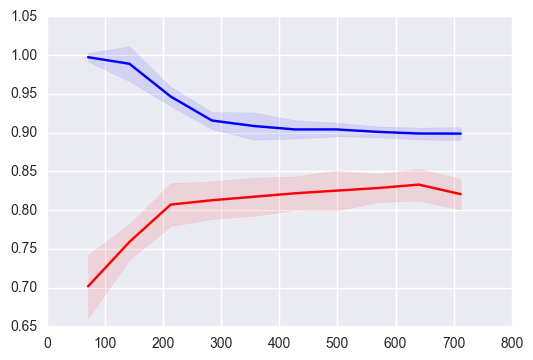

In [19]:
drawLearningCurve(clf_gb_gs, X, y)

- We have achieved around 20% increase in accuracy using tree-based classifieres like a decision tree, a random forest, and a boosting tree. 

# 6. Neural Network (Multilayer Perception)

In [20]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
import time

def fitNN(X,y):
    t1 = time.time()
    
    X_ohe = OneHotEncoder(categorical_features=[0,2,7]).fit_transform(X).toarray()
    y_ohe = OneHotEncoder().fit_transform(y.reshape(-1,1)).toarray()    
        
    model = Sequential()
    model.add(Dense(10, input_dim=X_ohe.shape[1], init='uniform', activation='sigmoid'))
    model.add(Dense(5, init='uniform', activation='sigmoid')) 
    model.add(Dropout(0.3))
    model.add(Dense(2, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])
    
    skf = StratifiedKFold(n_splits=5)
    train_scores = []
    test_scores = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X_ohe[train_index], X_ohe[test_index]
        y_train, y_test = y_ohe[train_index], y_ohe[test_index]

        model.fit(X_train, y_train, nb_epoch=10, batch_size=1, verbose=0)
        _, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
        _, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
        
        train_scores.append(train_accuracy)
        test_scores.append(test_accuracy)
    
    print('train mean accuracy: %.2f %% (std=%.2f %%)' %(np.mean(train_scores)*100, np.std(train_scores)*100))
    print('test mean accuracy: %.2f %% (std=%.2f %%)' %(np.mean(test_scores)*100, np.std(test_scores)*100))
    
    print('\n total time: %.2f sec.' %(time.time()-t1))
    return model

In [21]:
model = fitNN(X,y)

train mean accuracy: 82.69 % (std=1.27 %)
test mean accuracy: 81.61 % (std=3.75 %)

 total time: 41.98 sec.


- We see no significant improvement compared to tree-based classifiers. 